# IMPORT LIBARIES

https://huggingface.co/cardiffnlp/twitter-xlm-roberta-base-sentiment

In [51]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
from scipy.special import softmax
from transformers import DataCollatorWithPadding
import evaluate


# LOAD DATA

In [3]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [16]:
train.head(3)

,train_idx,text,label,label_text
0,0,i really do recommend this to anyone in need o...,1,positive
1,1,very good every day camera fits nicely in the ...,1,positive
2,2,"but , dollar for dollar , this dvd player is p...",1,positive


In [17]:
test.head(3)

,test_idx,text
0,0,fm receiver it has none
1,1,"the picture quality surprised me , when i firs..."
2,2,great video clip quality for a digital camera ...


In [20]:
# check if any colulumn has null values
train.isnull().sum()

train_idx     0
text          0
label         0
label_text    0
dtype: int64

In [19]:
test.isnull().sum()

test_idx    0
text        0
dtype: int64

In [22]:
train["label"].value_counts()

1    1926
0    1090
Name: label, dtype: int64

<Axes: >

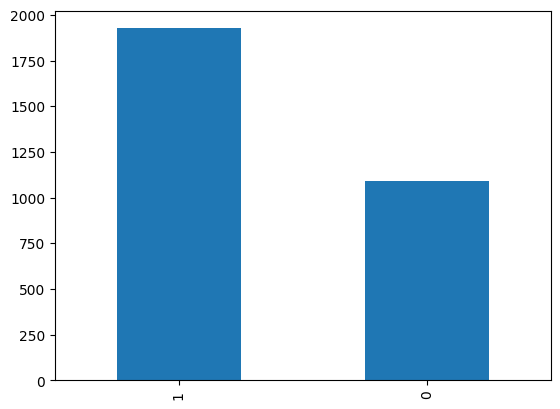

In [21]:
train["label"].value_counts().plot(kind='bar')

# TEST MODEL

In [14]:
from transformers import pipeline
model_path = "cardiffnlp/twitter-xlm-roberta-base-sentiment"
sentiment_task = pipeline("sentiment-analysis", model=model_path, tokenizer=model_path)
print(test['text'][np.random.randint(0, len(test))], "\n", sentiment_task(test['text'][np.random.randint(0, len(test))]))


the panorama setting is unbelievable ! 
 [{'label': 'positive', 'score': 0.5229542851448059}]


# Preprocess

In [42]:
from datasets import load_dataset

train = load_dataset('csv', data_files='data/train.csv')

Found cached dataset csv (/home/22021108Cristina/.cache/huggingface/datasets/csv/default-7e50772f604fcc87/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)


  0%|          | 0/1 [00:00<?, ?it/s]

In [43]:
# define the model name
model_name = f"cardiffnlp/twitter-xlm-roberta-base-sentiment"

In [44]:
# load roberta tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [45]:
# create a preprocessing function to tokenize text and truncate sequences to be no longer than roberta maximum input lengh
def preprocess_function(df):
    return tokenizer(df["text"], truncation=True)

In [46]:
# apply the preprocessing function to the train dataset
tokenized_train = train.map(preprocess_function, batched=True)

Loading cached processed dataset at /home/22021108Cristina/.cache/huggingface/datasets/csv/default-7e50772f604fcc87/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-fc8a92f23e652bde.arrow


In [48]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Evaluate

In [52]:
accuracy = evaluate.load("accuracy")

In [53]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [54]:
id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = {"NEGATIVE": 0, "POSITIVE": 1}

# MODEL

In [58]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_name)#, num_labels=2, id2label=id2label, label2id=label2id)


In [64]:
encoded_train = tokenizer(tokenized_train["train"]["text"], return_tensors="pt")
output_train = model(**encoded_train)
scores = output_train.logits

ValueError: Unable to create tensor, you should probably activate truncation and/or padding with 'padding=True' 'truncation=True' to have batched tensors with the same length. Perhaps your features (`input_ids` in this case) have excessive nesting (inputs type `list` where type `int` is expected).